In [ ]:
import kagglehub

# Загрузка датасета
DATASET_PATH = kagglehub.dataset_download('amirmotefaker/ab-testing-dataset')
print('Путь до директории с датасетом', DATASET_PATH)

100%|██████████| 2.07k/2.07k [00:00<00:00, 1.35MB/s]

Extracting files...
Путь до директории с датасетом /root/.cache/kagglehub/datasets/amirmotefaker/ab-testing-dataset/versions/1


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import shapiro

from warnings import simplefilter
simplefilter('ignore')

In [ ]:
control = pd.read_csv(f'{DATASET_PATH}/control_group.csv', sep = ";")
test = pd.read_csv(f'{DATASET_PATH}/test_group.csv', sep = ";")

In [ ]:
control.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
test.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


Посмотрим, свопадают ли размеры наших выборок


In [ ]:
print(f"В таблице контрольной выборки {control.shape[0]} строк и {control.shape[1]} столбцов.")

В таблице контрольной выборки 30 строк и 10 столбцов.


In [ ]:
print(f"В таблице тестовой выборки {test.shape[0]} строк и {test.shape[1]} столбцов.")

В таблице тестовой выборки 30 строк и 10 столбцов.


Проверим есть ли дубликаты в данных:

In [ ]:
print(f"В контрольной выборке {control.duplicated().sum()} дубликатов")

В контрольной выборке 0 дубликатов


In [ ]:
print(f"В тестовой выборке {test.duplicated().sum()} дубликатов")

В тестовой выборке 0 дубликатов


Посмотрим есть ли пропуски в таблицах:

In [ ]:
control.isnull().sum()

,0
Campaign Name,0
Date,0
Spend [USD],0
# of Impressions,1
Reach,1
# of Website Clicks,1
# of Searches,1
# of View Content,1
# of Add to Cart,1
# of Purchase,1


In [ ]:
test.isnull().sum()

,0
Campaign Name,0
Date,0
Spend [USD],0
# of Impressions,0
Reach,0
# of Website Clicks,0
# of Searches,0
# of View Content,0
# of Add to Cart,0
# of Purchase,0


Заполним пропуски в контрольной выборке нулевыми значениями по столбцам:

In [ ]:
columns_to_fill = [
    "# of Impressions", "Reach", "# of Website Clicks",
    "# of Searches", "# of View Content", "# of Add to Cart", "# of Purchase"
]

for column in columns_to_fill:
    control[column].fillna(value=0, inplace=True)

In [ ]:
control.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Приводим данные в тестовой и контрольной группах к одному типу (int64)
int_columns = control.select_dtypes(include=['float64']).columns
control[int_columns] = control[int_columns].astype('int64')

Проведем предварительный анализ данных:

In [ ]:
#Средние траты в день за месяц на рекламу в контрольной группе
avg_spend_value_control = control['Spend [USD]'].mean()
#Средние траты в день за месяц на рекламу в тестовой группе
avg_spend_value_test = test['Spend [USD]'].mean()

#Сумма, потраченная за месяц на рекламу в контрольной группе
total_spend_value_control = control['Spend [USD]'].sum()
#Сумма, потраченная за месяц на рекламу в тестовой группе
total_spend_value_test = test['Spend [USD]'].sum()
x_spend = ['контрольная группа', 'тестовая группа']
y_spend = [total_spend_value_control, total_spend_value_test]

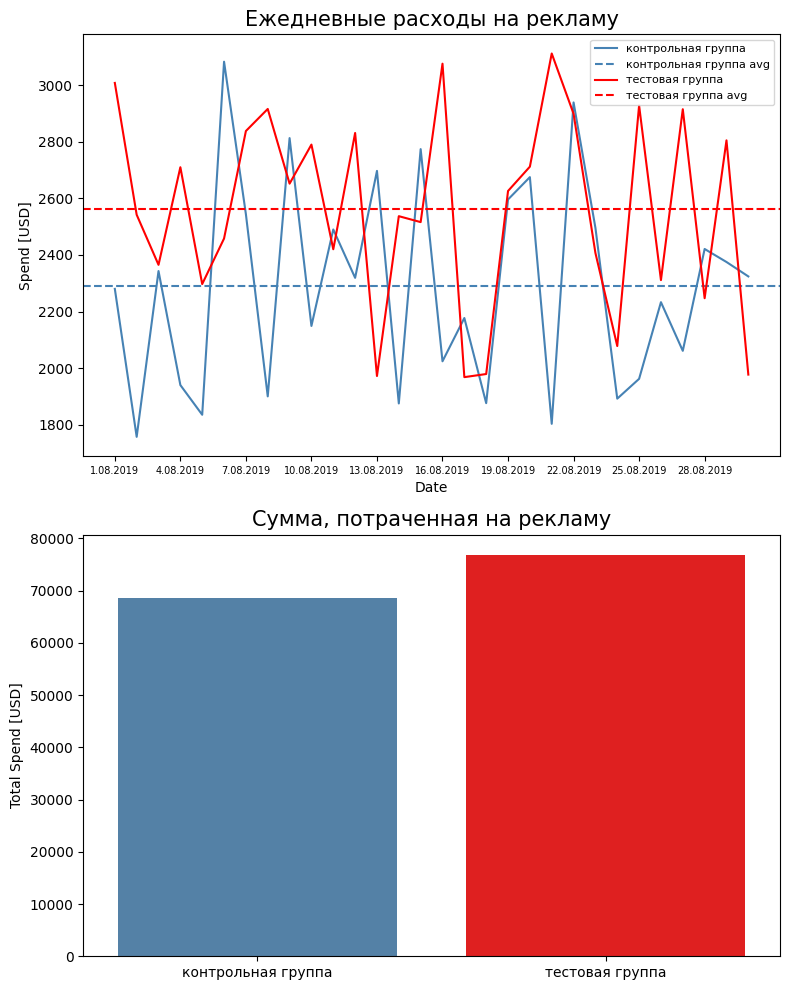

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(8, 10))
# Ежедневные траты контрольной группы на рекламу
ax1 = sns.lineplot(data=control, x='Date', y='Spend [USD]', color='steelblue', label='контрольная группа', ax=ax1)
# Линия среднего значения для контрольной группы
ax1.axhline(y=avg_spend_value_control, color='steelblue', ls='--', label='контрольная группа avg')

# Ежедневные траты тестовой группы на рекламу
ax1 = sns.lineplot(data=test, x='Date', y='Spend [USD]', color='red', label='тестовая группа', ax=ax1)
# Линия среднего значения для тестовой группы
ax1.axhline(y=avg_spend_value_test, ls='--', color='red', label='тестовая группа avg')

step_date = 3
dates = control['Date'].unique()
ax1.set_xticks(range(0, len(dates), step_date))
ax1.set_xticklabels(dates[::step_date], size=7)
ax1.set_title('Ежедневные расходы на рекламу', size=15)
ax1.legend(fontsize=8, loc='upper right')

ax2 = sns.barplot(x=x_spend, y=y_spend, palette=['steelblue', 'red'])
ax2.set_ylabel('Total Spend [USD]')
ax2.set_title('Сумма, потраченная на рекламу', size=15)

plt.tight_layout()

In [ ]:
print(f"Сумма, потраченная на рекламу в контрольной группе: {total_spend_value_control}")
print(f"Сумма, потраченная на рекламу в тестовой группе: {total_spend_value_test}")
print(f"Разница в процентах: {((total_spend_value_test-total_spend_value_control)/total_spend_value_control) * 100:.2f} %")

Сумма, потраченная на рекламу в контрольной группе: 68653
Сумма, потраченная на рекламу в тестовой группе: 76892
Разница в процентах: 12.00 %


На графиках мы видим, сумма, потраченная на рекламу в тестовой группе больше на 12 %, чем в контрольной.

In [ ]:
# Считаем среднее количество показов в день
avg_impressions_control = control['# of Impressions'].mean()
avg_impressions_test = test['# of Impressions'].mean()

# Считаем сумму показов за весь период
total_impressions_control = control['# of Impressions'].sum()
total_impressions_test = test['# of Impressions'].sum()

x_impressions = ['контрольная группа', 'тестовая группа']
y_impressions = [total_impressions_control, total_impressions_test]

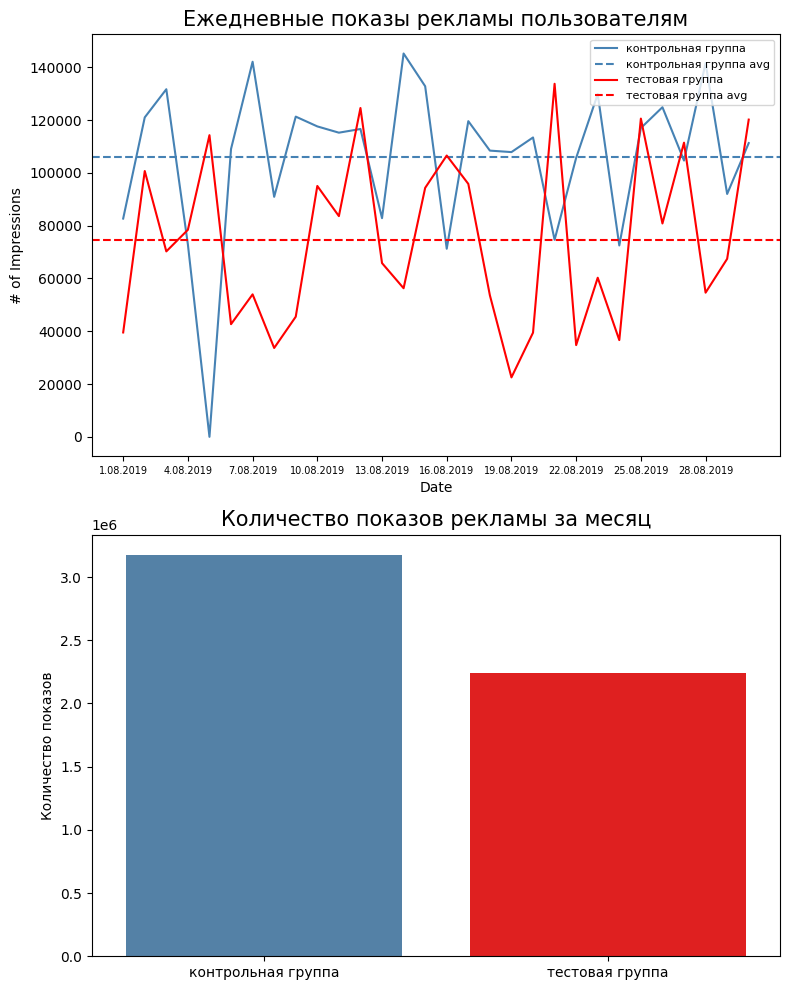

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(8, 10))
# Ежедневное количество показов в контрольной группе
ax1 = sns.lineplot(data=control, x='Date', y='# of Impressions', color='steelblue', label='контрольная группа', ax=ax1)
# Среднее количетсво показов за месяц в контрольной группе
ax1.axhline(y=avg_impressions_control, color='steelblue', ls='--', label='контрольная группа avg')

# Ежедневное количество показов в тестовой группе
ax1 = sns.lineplot(data=test, x='Date', y='# of Impressions', color='red', label='тестовая группа', ax=ax1)
# Среднее количетсво показов за месяц в тестовой группе
ax1.axhline(y=avg_impressions_test, ls='--', color='red', label='тестовая группа avg')

step_date = 3
dates = control['Date'].unique()
ax1.set_xticks(range(0, len(dates), step_date))
ax1.set_xticklabels(dates[::step_date], size=7)
ax1.set_title('Ежедневные показы рекламы пользователям', size=15)
ax1.legend(fontsize=8, loc='upper right')

ax2 = sns.barplot(x=x_impressions, y=y_impressions, palette=['steelblue', 'red'])
ax2.set_ylabel('Количество показов')
ax2.set_title('Количество показов рекламы за месяц', size=15)

plt.tight_layout()

In [ ]:
print(f"Количество показов рекламы за месяц в контрольной группе: {total_impressions_control}")
print(f"Количество показов рекламы за месяц в тестовой группе: {total_impressions_test}")
print(f"Разница в процентах: {((total_impressions_control-total_impressions_test)/total_impressions_test) * 100:.2f} %")

Количество показов рекламы за месяц в контрольной группе: 3177233
Количество показов рекламы за месяц в тестовой группе: 2237544
Разница в процентах: 42.00 %


Графики показывают, что в контрольной группе было на 42% больше показов рекламы,чем в тестовой. С учетом суммы,потраченной на рекламу в каждой группе, реклама контрольной группы стоила дешевле.

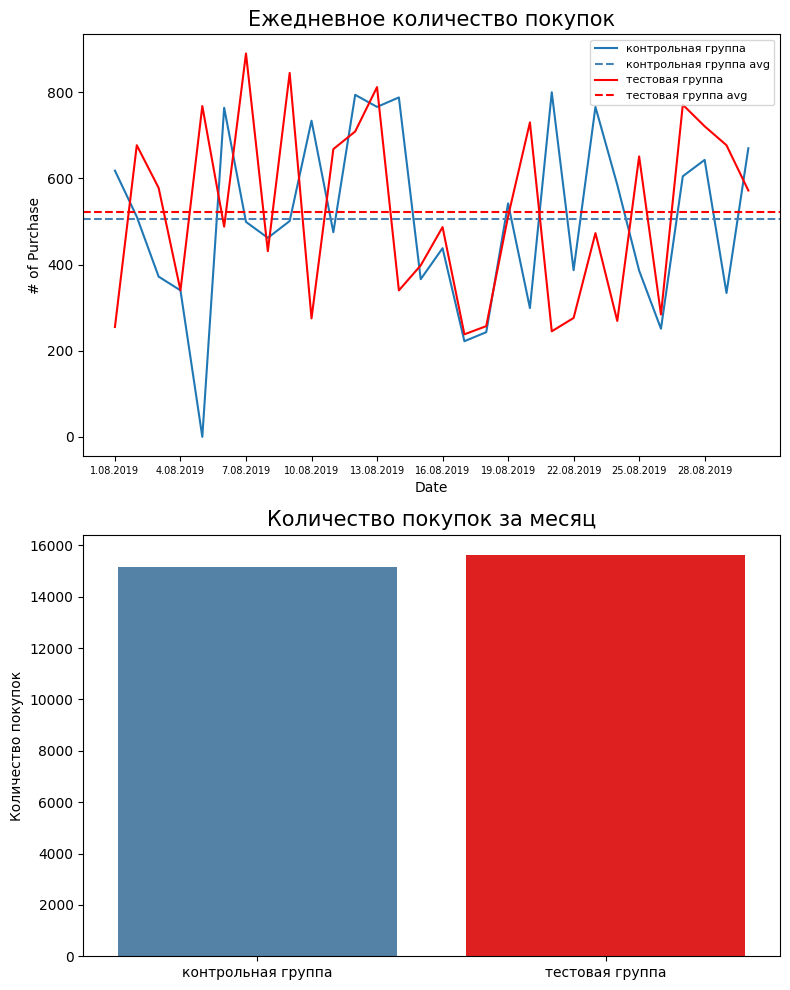

In [ ]:
# Расчет среднего количества покупок для каждой группы
avg_purchase_control = control['# of Purchase'].mean()
avg_purchase_test = test['# of Purchase'].mean()

# Расчет общего количества покупок для каждой группы
total_purchase_control = control['# of Purchase'].sum()
total_purchase_test = test['# of Purchase'].sum()

x_purchase = ['контрольная группа', 'тестовая группа']
y_purchase = [total_purchase_control, total_purchase_test]


fig, (ax1,ax2) = plt.subplots(ncols=1, nrows=2, figsize=(8, 10))
#Ежедневное количество покупок в контрольной группе
ax1 = sns.lineplot(data=control, x='Date', y='# of Purchase', label='контрольная группа', ax=ax1)
#Среднее количество покупок в день в контрольной группе
ax1.axhline(y=avg_purchase_control, color='steelblue', ls='--', label='контрольная группа avg')

#Ежедневное количество покупок в тестовой группе
ax1 = sns.lineplot(data=test, x='Date', y='# of Purchase', color='red', label='тестовая группа', ax=ax1)
#Среднее количество покупок в день в тестовой группе
ax1.axhline(y=avg_purchase_test, ls='--', color='red', label='тестовая группа avg')

ax1.set_xticks(range(0, len(dates), step_date))
ax1.set_xticklabels(dates[::step_date], size=7)
ax1.set_title('Ежедневное количество покупок', size=15)
ax1.legend(fontsize=8, loc='upper right')


ax2 = sns.barplot(x=x_purchase, y=y_purchase, palette=['steelblue', 'red'])
ax2.set_ylabel('Количество покупок')
ax2.set_title('Количество покупок за месяц', size=15)

plt.tight_layout()


In [ ]:
print(f'Количество покупок за месяц в контрольной группе: {total_purchase_control}')
print(f'Количество покупок за месяц в тестовой группе: {total_purchase_test}')
print(f"Разница в процентах: {((total_purchase_test-total_purchase_control)/total_purchase_control) * 100:.2f} %")

Количество покупок за месяц в контрольной группе: 15161
Количество покупок за месяц в тестовой группе: 15637
Разница в процентах: 3.14 %


На графиках видно, что клиенты совершили примерно одинаковое количество покупок в контрольной и тестовой группе.


Проверим, есть ли отклонения в контрольной и тестовой выборках. Чтобы убедиться, что анализ не искажен экстремальными значениями, используем метод межквартильного диапазона (IQR).


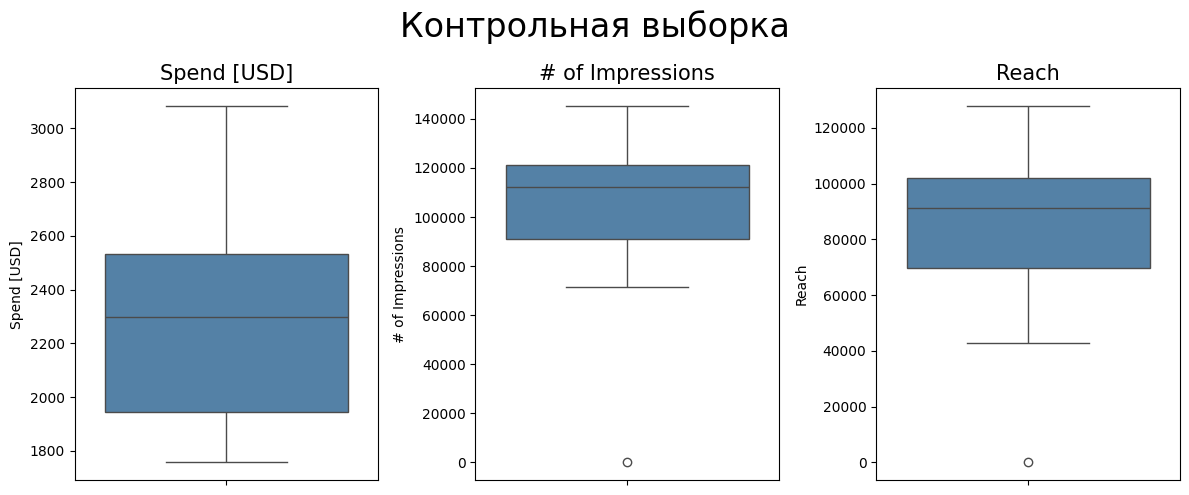

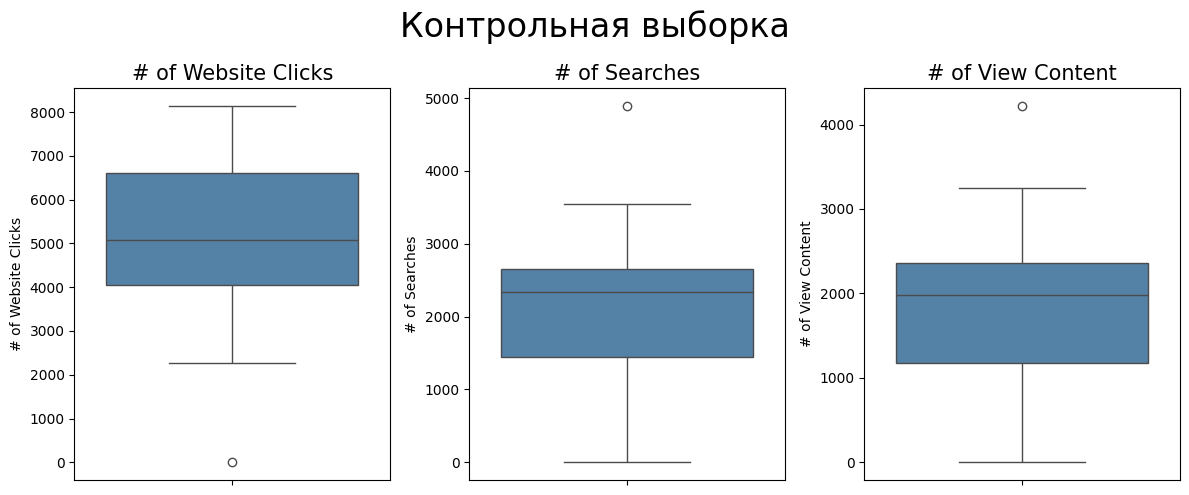

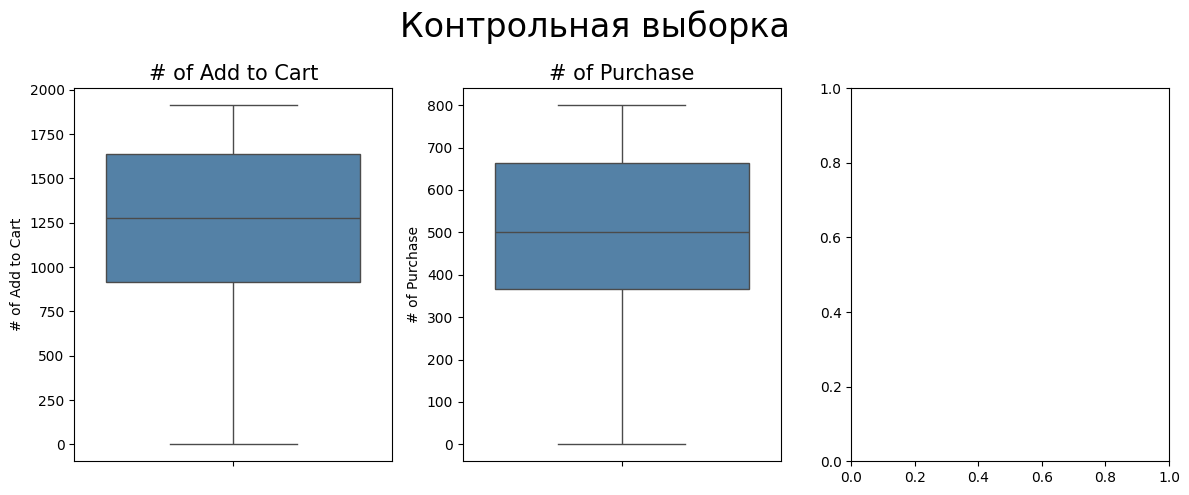

In [ ]:
features = [
    'Spend [USD]',
    '# of Impressions',
    'Reach',
    '# of Website Clicks',
    '# of Searches',
    '# of View Content',
    '# of Add to Cart',
    '# of Purchase'
]


def plot_boxplots(data, grouptype, color):

    for i in range(3):

        fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(12,5))
        ax1 = sns.boxplot(data[features[i*3]], ax=ax1, color=color)
        ax1.set_title(str(features[i*3]), fontsize=15)
        ax2 = sns.boxplot(data[features[i*3+1]], ax=ax2, color=color)
        ax2.set_title(str(features[i*3+1]), fontsize=15)
        if i < 2:

            ax3 = sns.boxplot(data[features[i*3+2]], ax=ax3, color=color)
            ax3.set_title(str(features[i*3+2]), fontsize=15)

        fig.suptitle(f"{grouptype}", fontsize=24)

        plt.tight_layout()

plot_boxplots(control, 'Контрольная выборка', 'steelblue')

Боксплоты нам показали, что выбросы есть. Посчитаем, сколько процентов они составляют в каждом столбце в контрольной выборке.

In [ ]:
def outliers_percentage(data):

    outliers_perc = [] # для хранения результатов

    for k,v in data.items():
        # k - название столбца, v - данные столбца
        if data[k].dtype != 'O':
            q1 = v.quantile(0.25)
            q3 = v.quantile(0.75)
            irq = q3 - q1
            v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
            perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
            out_tuple = (k,int(perc))
            outliers_perc.append(out_tuple)
            print("В столбце %s процент выбросов равен %.2f" % (k,perc))

outliers_percentage(control)

В столбце Spend [USD] процент выбросов равен 0.00
В столбце # of Impressions процент выбросов равен 3.33
В столбце Reach процент выбросов равен 3.33
В столбце # of Website Clicks процент выбросов равен 3.33
В столбце # of Searches процент выбросов равен 3.33
В столбце # of View Content процент выбросов равен 3.33
В столбце # of Add to Cart процент выбросов равен 0.00
В столбце # of Purchase процент выбросов равен 0.00


Посчитаем, сколько процентов выбросы составляют в каждом столбце в тестовой выборке.

In [ ]:
outliers_percentage(test)

В столбце Spend [USD] процент выбросов равен 0.00
В столбце # of Impressions процент выбросов равен 0.00
В столбце Reach процент выбросов равен 0.00
В столбце # of Website Clicks процент выбросов равен 0.00
В столбце # of Searches процент выбросов равен 0.00
В столбце # of View Content процент выбросов равен 0.00
В столбце # of Add to Cart процент выбросов равен 0.00
В столбце # of Purchase процент выбросов равен 0.00


Удалим выбросы:

In [ ]:
def remove_outliers_iqr(data, column):

    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return filtered_data


capped_control_group = control.copy()
capped_test_group = test.copy()

# Данные без выбросов
for col in features:

    capped_control_group = remove_outliers_iqr(capped_control_group, col)
    capped_test_group = remove_outliers_iqr(capped_test_group, col)

Построим боксплоты после удаления выбросов:



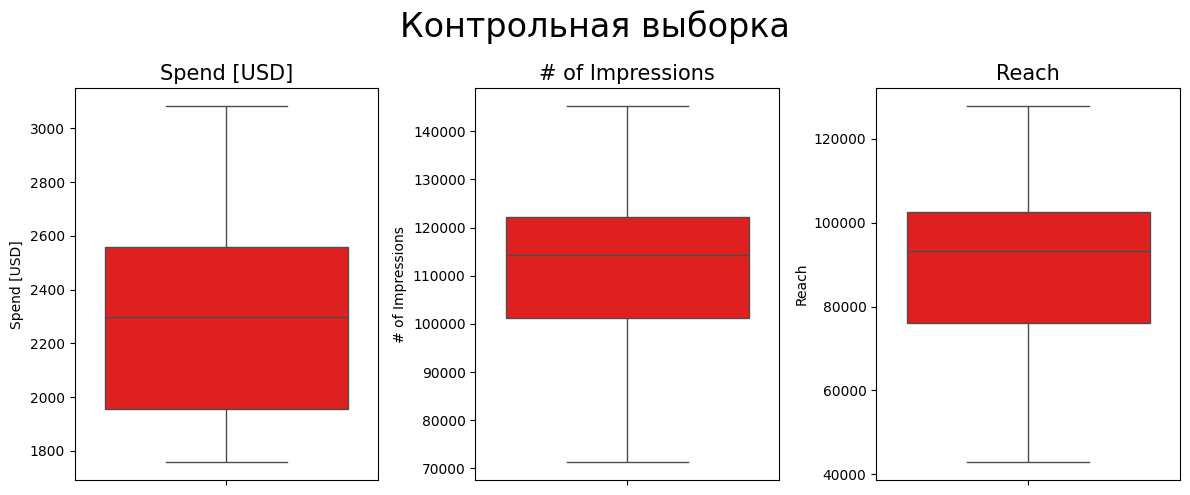

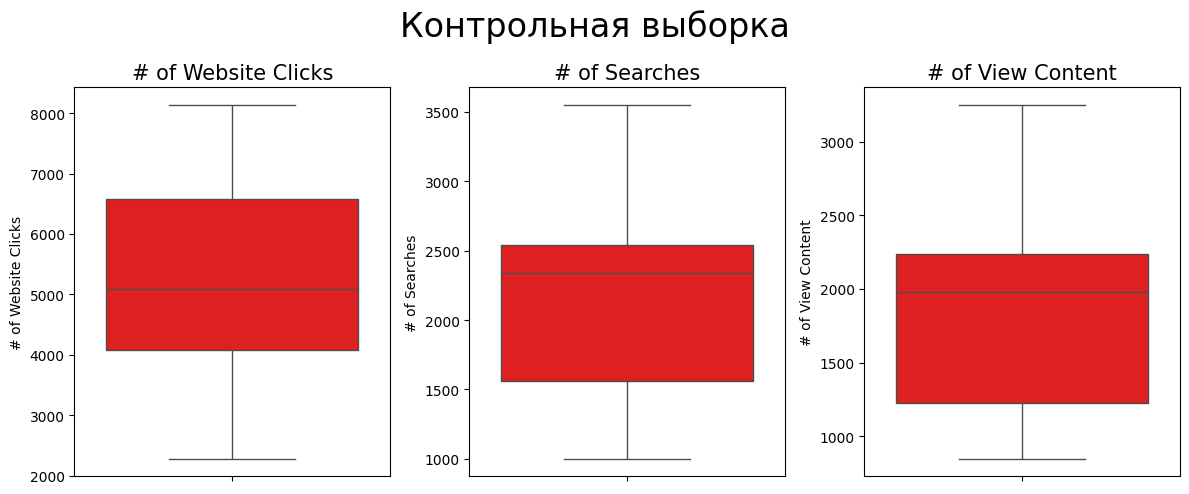

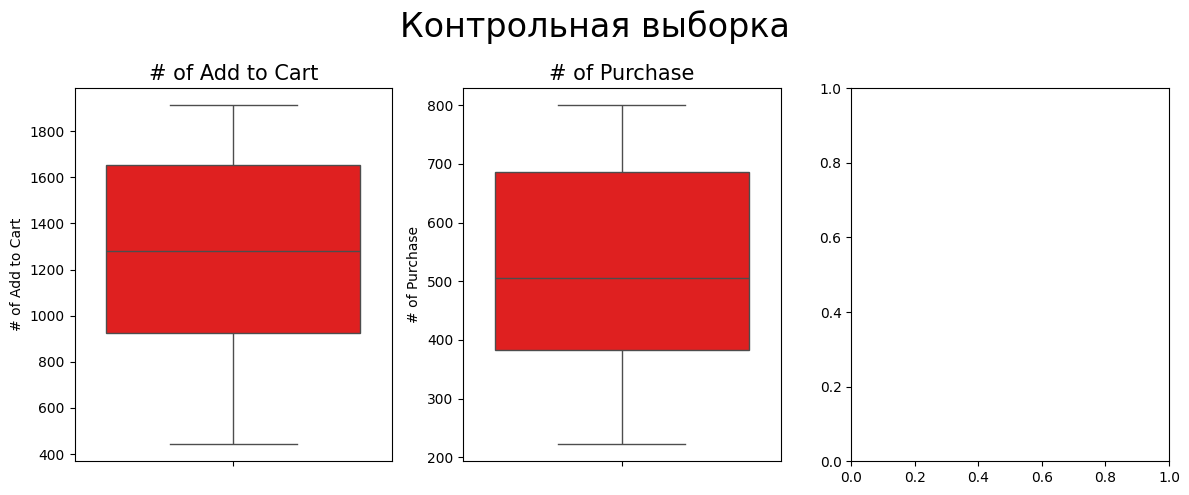

In [ ]:
plot_boxplots(capped_control_group, 'Контрольная выборка', 'red')

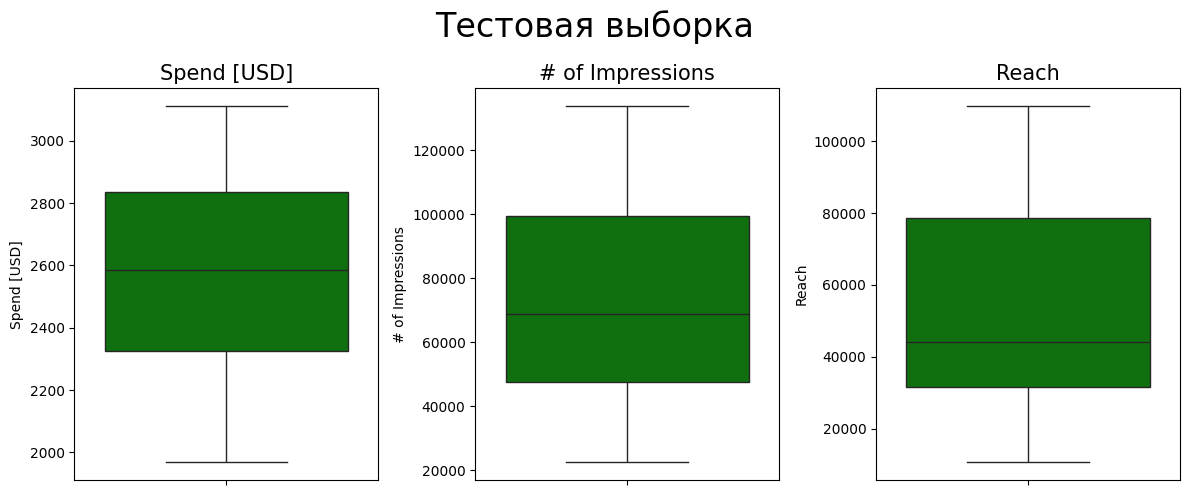

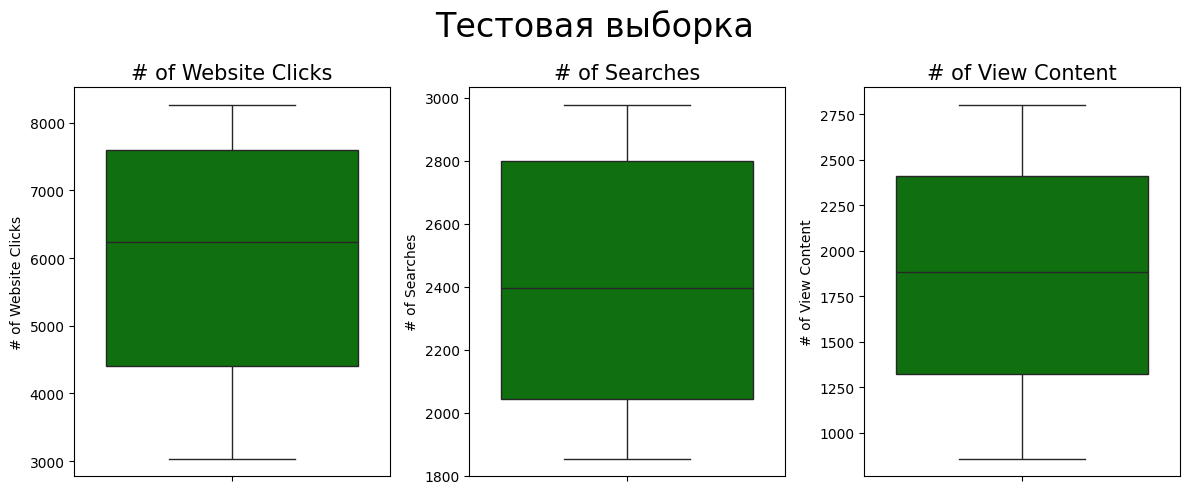

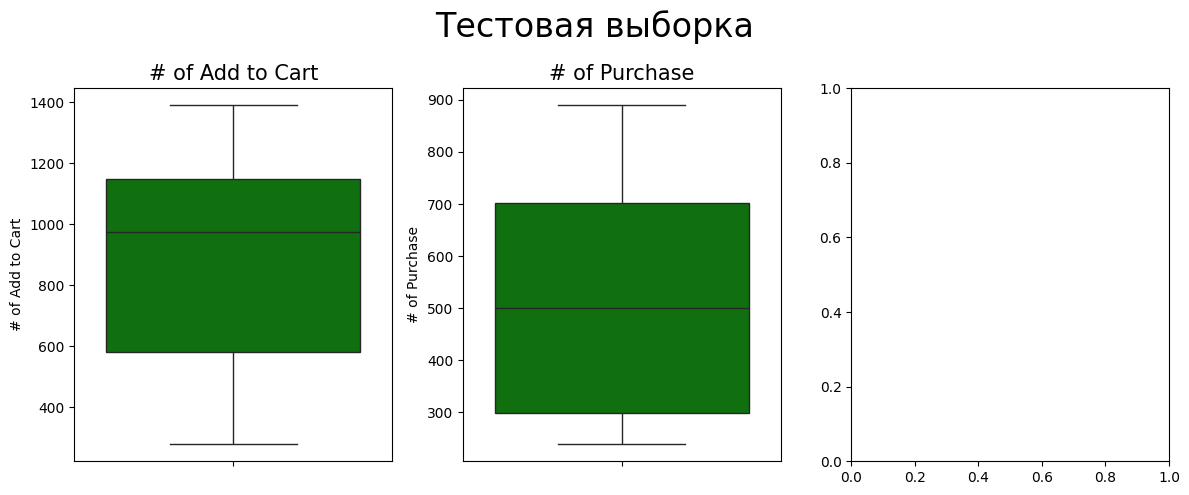

In [ ]:
plot_boxplots(capped_test_group, 'Тестовая выборка', 'green')

Посчитаем метрики после удаления выбросов:

In [ ]:
# Конверсия (процент посетителей сайта, совершивших покупку) (Покупки / Клики на сайт)
capped_control_group['Conversion Rate'] = capped_control_group['# of Purchase'] / capped_control_group['# of Website Clicks']

capped_test_group['Conversion Rate'] = capped_test_group['# of Purchase'] / capped_test_group['# of Website Clicks']

# Стоимость клика (Расходы / Количество кликов на сайт)
capped_control_group['Cost per Click'] = capped_control_group['Spend [USD]'] / capped_control_group['# of Website Clicks']

capped_test_group['Cost per Click'] = capped_test_group['Spend [USD]'] / capped_test_group['# of Website Clicks']

# Средняя стоимость одной покупки (Расходы / Количество покупок)
capped_control_group['Cost per Purchase'] = capped_control_group['Spend [USD]'] / capped_control_group['# of Purchase']

capped_test_group['Cost per Purchase'] = capped_test_group['Spend [USD]'] / capped_test_group['# of Purchase']

# Click-through Rate - процент пользователей, кликнувших на сайт, после показа рекламы (Клики / Количество показов )
capped_control_group['Click-through Rate'] = capped_control_group['# of Website Clicks'] / capped_control_group['# of Impressions']

capped_test_group['Click-through Rate'] = capped_test_group['# of Website Clicks'] / capped_test_group['# of Impressions']



In [ ]:
capped_control_group.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase,Conversion Rate,Cost per Click,Cost per Purchase,Click-through Rate
0,Control Campaign,1.08.2019,2280,82702,56930,7016,2290,2159,1819,618,0.088084,0.324971,3.689320,0.084835
1,Control Campaign,2.08.2019,1757,121040,102513,8110,2033,1841,1219,511,0.063009,0.216646,3.438356,0.067003
2,Control Campaign,3.08.2019,2343,131711,110862,6508,1737,1549,1134,372,0.057160,0.360018,6.298387,0.049411
3,Control Campaign,4.08.2019,1940,72878,61235,3065,1042,982,1183,340,0.110930,0.632953,5.705882,0.042057
5,Control Campaign,6.08.2019,3083,109076,87998,4028,1709,1249,784,764,0.189672,0.765392,4.035340,0.036928


In [ ]:
capped_test_group.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase,Conversion Rate,Cost per Click,Cost per Purchase,Click-through Rate
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255,0.083937,0.990125,11.796078,0.076814
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677,0.145373,0.545845,3.754801,0.046238
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578,0.073304,0.299937,4.091696,0.112221
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340,0.080645,0.642789,7.970588,0.053741
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768,0.130991,0.391779,2.990885,0.051297


Визуализируем метрики:

In [ ]:
metrics = ['Conversion Rate', 'Cost per Click', 'Cost per Purchase', 'Click-through Rate']

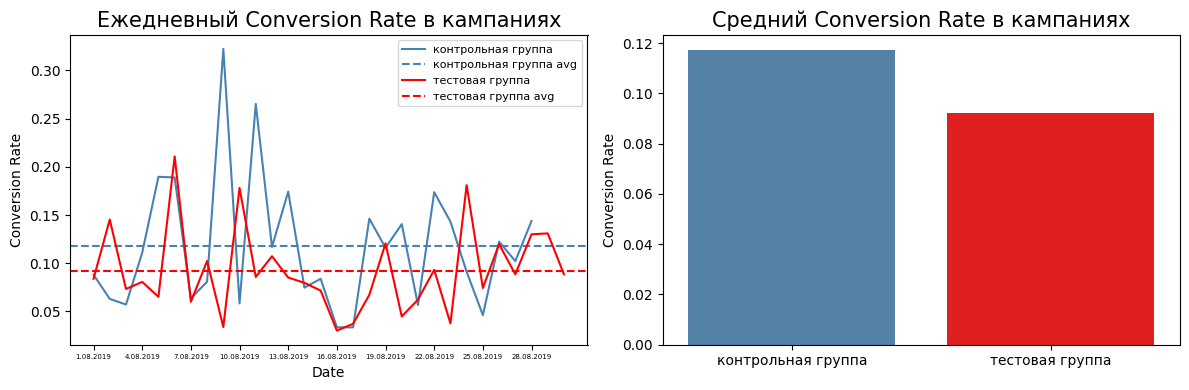

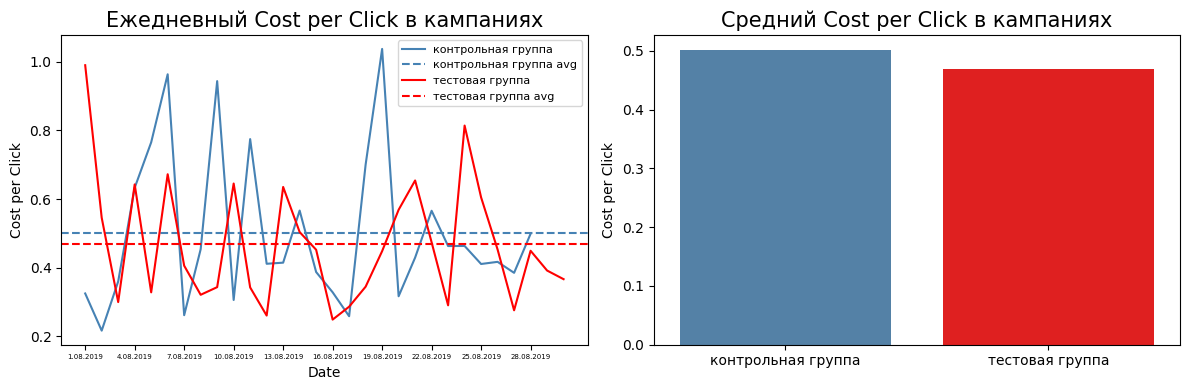

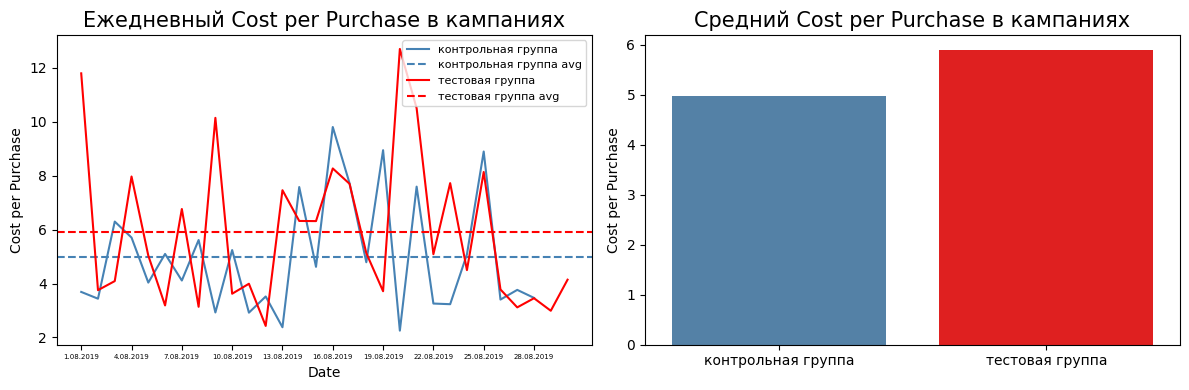

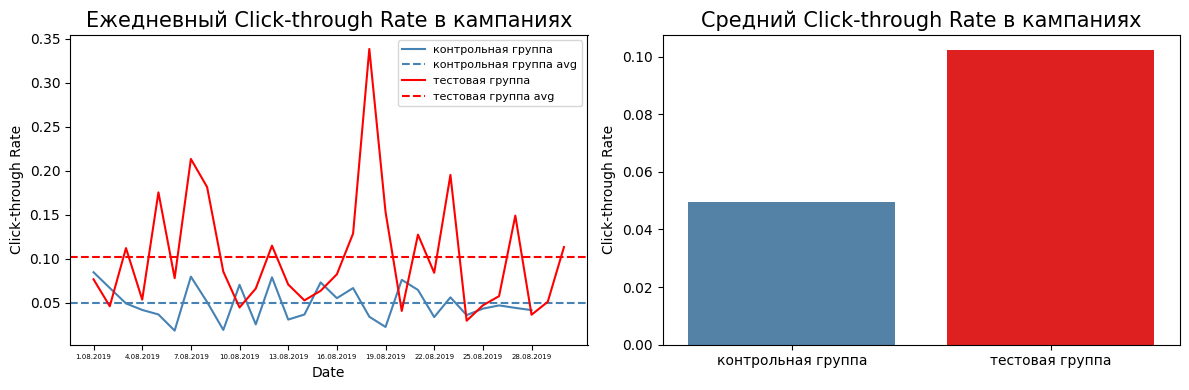

In [ ]:
for metric in metrics:
    # Cредние значения метрик для обеих групп
    avg_control_metric = capped_control_group[metric].mean()
    avg_test_metric    = capped_test_group[metric].mean()
    x_metric = ['контрольная группа', 'тестовая группа']
    y_metric = [avg_control_metric, avg_test_metric]

    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,4))

    ax1 = sns.lineplot(data=capped_control_group, x='Date', y=metric, color='steelblue', label='контрольная группа', ax=ax1)
    ax1.axhline(y=avg_control_metric, color='steelblue', ls='--', label='контрольная группа avg')

    ax1 = sns.lineplot(data=capped_test_group, x='Date', y=metric, color='red', label='тестовая группа', ax=ax1)
    ax1.axhline(y=avg_test_metric, ls='--', color='red', label='тестовая группа avg')

    ax1.set_xticks(range(0, len(dates), step_date))
    ax1.set_xticklabels(dates[::step_date], size=5)
    ax1.set_title(f'Ежедневный {metric} в кампаниях', size=15)
    ax1.legend(fontsize=8)


    ax2 = sns.barplot(x=x_metric, y=y_metric, palette=['steelblue', 'red'])
    ax2.set_ylabel(f'{metric}')
    ax2.set_title(f'Средний {metric} в кампаниях', size=15)

    plt.tight_layout()

Мы видим:

Разница в Conversion Rate между средними значениями в тестовой и контрольной группах небольшая.

Разница в Cost per Click между средними значениями в тестовой и контрольной группах небольшая.

Разница в Cost per Purchase между средними значениями в тестовой и контрольной группах небольшая.

Разница в Click-through Rate между средними значениями в тестовой и контрольной группах большая.

Проверим нормально ли распределены данные в метриках:

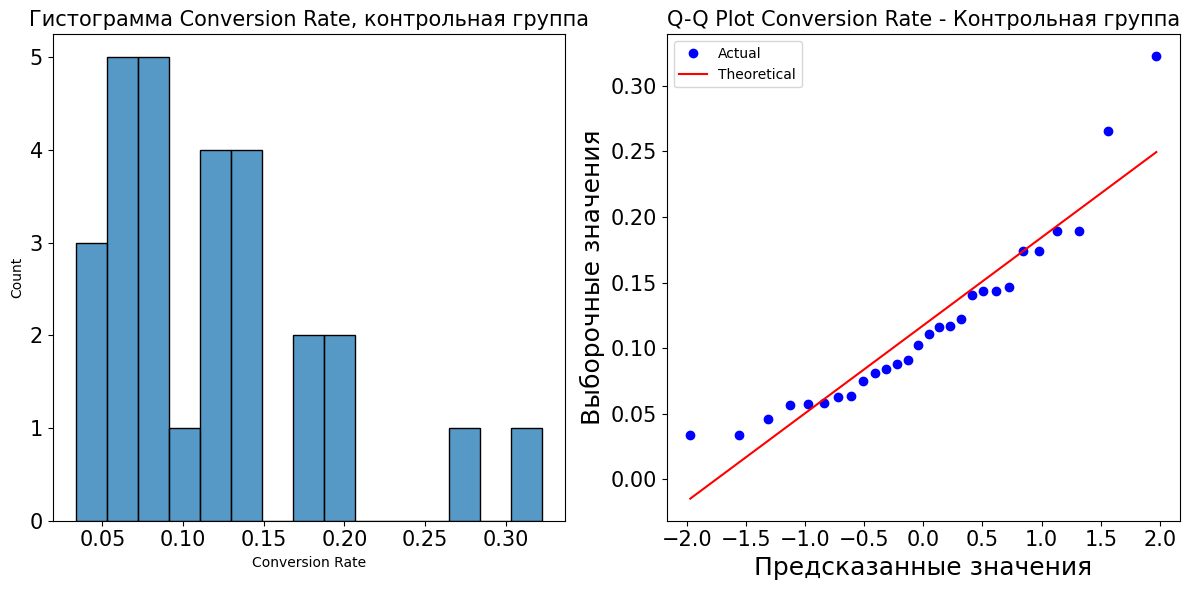

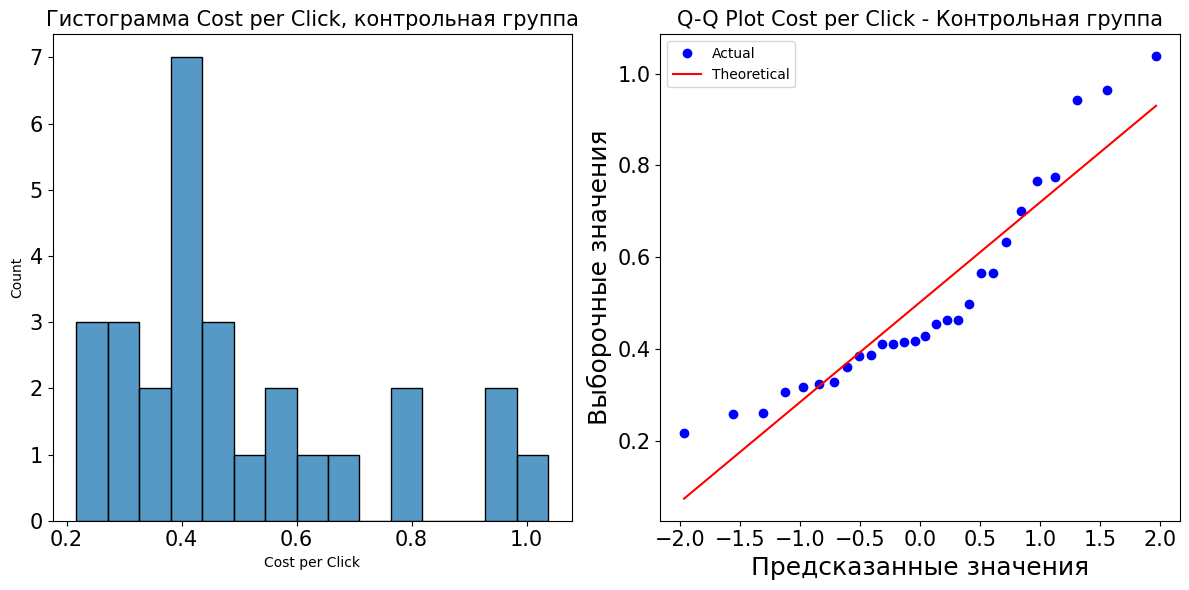

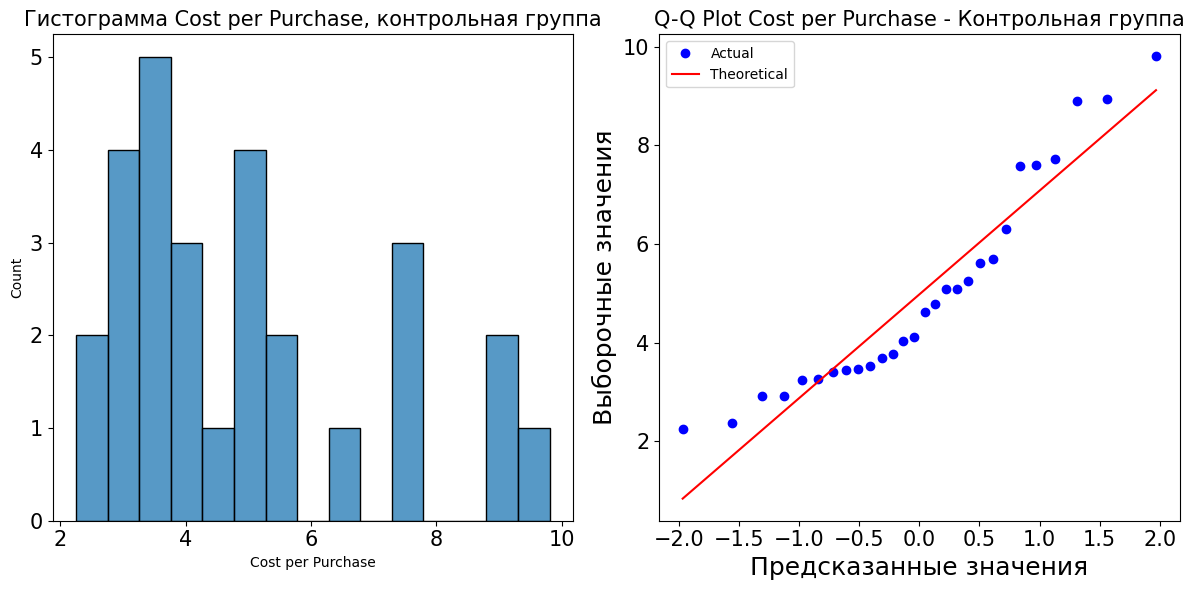

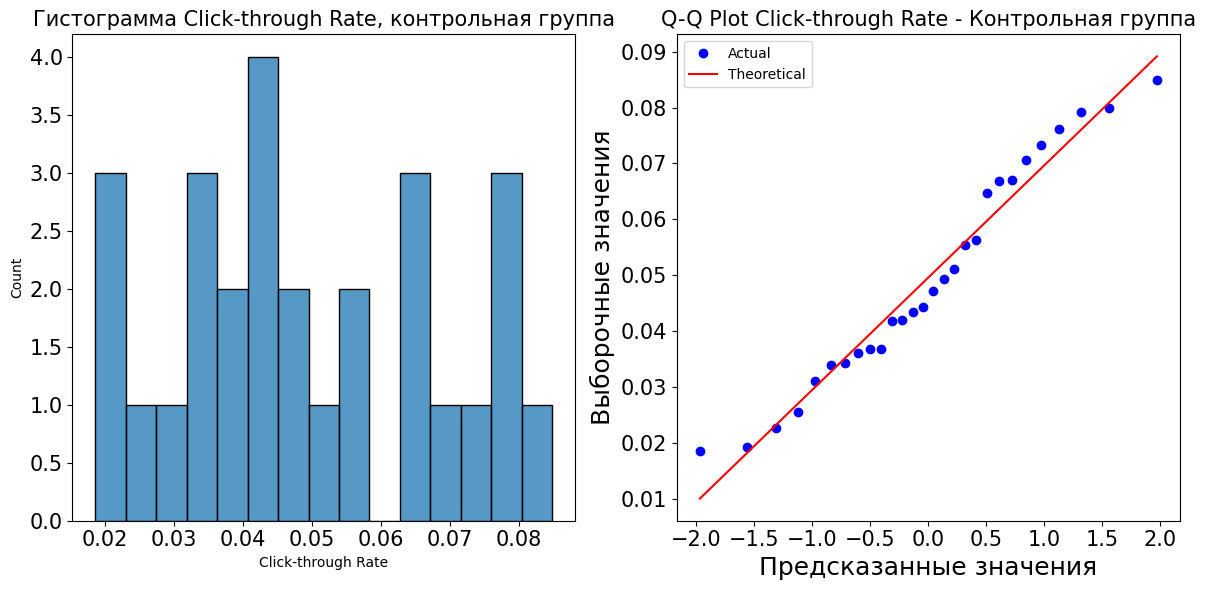

In [ ]:

for metric in metrics:

    fig,axes = plt.subplots(1,2,figsize=(12,6))

    axes[0] = sns.histplot(capped_control_group[metric], bins=15, ax=axes[0])
    axes[0].xaxis.set_tick_params(labelsize=15)
    axes[0].yaxis.set_tick_params(labelsize=15)
    axes[0].set_title(f"Гистограмма {metric}, контрольная группа",fontsize=15)

    axes[1] = stats.probplot(capped_control_group[metric], dist="norm", plot=plt)
    plt.legend(['Actual','Theoretical'])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("Предсказанные значения", fontsize=18)
    plt.ylabel('Выборочные значения', fontsize=18)
    plt.title(f"Q-Q Plot {metric} - Контрольная группа", fontsize=15)

    plt.tight_layout()

Мы видим, что данные не распределены нормально. Это может быть объяснено небольшим размером выборки. Проверим точно ли это с помощью теста Шапиро-Уилка. Тест отвергает гипотезу о нормальности (H0), если значение p-value меньше или равно 0,05.


In [ ]:
for metric in metrics:

    print(f'\n{metric}:')

    test_stat, pvalue = shapiro(capped_control_group[metric])
    print('Контрольная группа: Тест Шапиро-Уилка = %.4f, p-value = %.4f' % (test_stat, pvalue))

    test_stat, pvalue = shapiro(capped_test_group[metric])
    print('Тестовая группа: Тест Шапиро-Уилка = %.4f, p-value = %.4f' % (test_stat, pvalue))


Conversion Rate:
Контрольная группа: Тест Шапиро-Уилка = 0.8978, p-value = 0.0102
Тестовая группа: Тест Шапиро-Уилка = 0.9255, p-value = 0.0373

Cost per Click:
Контрольная группа: Тест Шапиро-Уилка = 0.8821, p-value = 0.0045
Тестовая группа: Тест Шапиро-Уилка = 0.9114, p-value = 0.0162

Cost per Purchase:
Контрольная группа: Тест Шапиро-Уилка = 0.9008, p-value = 0.0119
Тестовая группа: Тест Шапиро-Уилка = 0.8966, p-value = 0.0069

Click-through Rate:
Контрольная группа: Тест Шапиро-Уилка = 0.9543, p-value = 0.2531
Тестовая группа: Тест Шапиро-Уилка = 0.8409, p-value = 0.0004


Данный тест подтверждает, что значения метрик не распределены нормально, так как значения p-value < 0,05 везде, кроме теста на количество кликов.

Теперь нам нужно проверить равенство дисперсий. Сделаем это с помощью теста Левена:

In [ ]:
for metric in metrics:
    levene_test = stats.levene(capped_control_group[metric], capped_test_group[metric])
    print(f"Тест Левена для оценки равенства дисперсий: {metric}")
    print(f"Тест Левена {levene_test.statistic}, p-value = {levene_test.pvalue}")

Тест Левена для оценки равенства дисперсий: Conversion Rate
Тест Левена 3.3102851848423023, p-value = 0.07419480287654955
Тест Левена для оценки равенства дисперсий: Cost per Click
Тест Левена 0.30735579995268336, p-value = 0.5815147351477551
Тест Левена для оценки равенства дисперсий: Cost per Purchase
Тест Левена 1.7399012133302252, p-value = 0.1925197772263418
Тест Левена для оценки равенства дисперсий: Click-through Rate
Тест Левена 9.938599305698453, p-value = 0.0026003006411090416


Для проверки на статистическую значимость подойдет тест Манна-Уитни, так как выборки небольшие, данные не распределены нормально, дисперсии разные.

In [ ]:
for metric in metrics:

    print(f'\n{metric}:')
    print(stats.mannwhitneyu(capped_control_group[metric], capped_test_group[metric]))


Conversion Rate:
MannwhitneyuResult(statistic=np.float64(499.0), pvalue=np.float64(0.22189553147773622))

Cost per Click:
MannwhitneyuResult(statistic=np.float64(445.0), pvalue=np.float64(0.7030299918355747))

Cost per Purchase:
MannwhitneyuResult(statistic=np.float64(342.0), pvalue=np.float64(0.22783958084713474))

Click-through Rate:
MannwhitneyuResult(statistic=np.float64(175.0), pvalue=np.float64(0.00014205949265144692))


Согласно этим результатам:

Разница в коэффициентах конверсии между контрольной и тестовой группами НЕ является статистически значимой.
Разница в цене за клик между контрольной и тестовой группами НЕ является статистически значимой.
Разница в цене за покупку между контрольной и тестовой группами НЕ является статистически значимой.
Разница в показах на последних страницах между контрольной и тестовой группами ЯВЛЯЕТСЯ статистически значимой.

Таким образом, тестовая рекламная кампания не оказывает существенного влияния на коэффициент конверсии, цену за клик и цену за покупку. Получается, у новой (тестовой) кампании нет очевидных и явных преимуществ.